In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

NUMERICS = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [2]:
def read_rank_file(file_path):
	rank_df = pd.read_csv(file_path, sep='\t', header=None, names=['entity', 'type'])
	rank_df['rank'] = rank_df['type'].apply(lambda x: int(x.split(' ')[1]))
	rank_df['type'] = rank_df['type'].apply(lambda x: x.split(' ')[0])
	return rank_df

rank_passive = read_rank_file('rank_passive.txt')
rank = read_rank_file('rank.txt')

rank.describe()

,rank
count,5864.000000
mean,1340.163370
std,3239.262374
min,1.000000
25%,2.000000
50%,16.000000
75%,218.250000
max,18180.000000


In [3]:
rank_passive.describe()

,rank
count,5864.000000
mean,1197.261426
std,2881.126551
min,1.000000
25%,2.000000
50%,16.000000
75%,236.000000
max,18208.000000


In [4]:
df_rank_diff = pd.merge(rank, rank_passive, on=['entity', 'type'], suffixes=('_sampling', '_passive'))
df_rank_diff["rank_diff"] = df_rank_diff['rank_sampling'] - df_rank_diff['rank_passive']
df_rank_diff.describe()

,rank_sampling,rank_passive,rank_diff
count,5864.000000,5864.000000,5864.000000
mean,1340.163370,1197.261426,142.901944
std,3239.262374,2881.126551,1580.336363
min,1.000000,1.000000,-17121.000000
25%,2.000000,2.000000,-9.000000
50%,16.000000,16.000000,0.000000
75%,218.250000,236.000000,16.250000
max,18180.000000,18208.000000,14504.000000


In [6]:
df_rank_diff[(df_rank_diff['rank_sampling'] > 10) & (df_rank_diff['rank_passive'] > 10)].describe()

,rank_sampling,rank_passive,rank_diff
count,2862.000000,2862.000000,2862.000000
mean,2729.631377,2442.326695,287.304682
std,4205.368494,3736.891622,2239.350272
min,11.000000,11.000000,-17121.000000
25%,50.250000,49.000000,-127.000000
50%,229.500000,247.500000,3.000000
75%,4983.000000,4113.750000,328.750000
max,18180.000000,18208.000000,14504.000000


In [7]:
print('Nombre de prédiction entrant dans le top 10 :', df_rank_diff[(df_rank_diff["rank_diff"] > 0) & (df_rank_diff['rank_passive'] <= 10) & (df_rank_diff['rank_sampling'] > 10)].count().values[0])
print('Nombre de prédiction entrant dans le top 3  :', df_rank_diff[(df_rank_diff["rank_diff"] > 0) & (df_rank_diff['rank_passive'] <= 3) & (df_rank_diff['rank_sampling'] > 3)].count().values[0])
print('Nombre de prédiction entrant dans le top 1  :', df_rank_diff[(df_rank_diff["rank_diff"] > 0) & (df_rank_diff['rank_passive'] <= 1) & (df_rank_diff['rank_sampling'] > 1)].count().values[0])
print('Total entrant dans le top 10     :', df_rank_diff[(df_rank_diff['rank_passive'] <= 10)].count().values[0])
print()
print('Nombre de prédiction sortant du top 10 :', df_rank_diff[(df_rank_diff["rank_diff"] < 0) & (df_rank_diff['rank_passive'] > 10) & (df_rank_diff['rank_sampling'] <= 10)].count().values[0])
print('Nombre de prédiction sortant du top 3  :', df_rank_diff[(df_rank_diff["rank_diff"] < 0) & (df_rank_diff['rank_passive'] > 3) & (df_rank_diff['rank_sampling'] <= 3)].count().values[0])
print('Nombre de prédiction sortant du top 1  :', df_rank_diff[(df_rank_diff["rank_diff"] < 0) & (df_rank_diff['rank_passive'] > 1) & (df_rank_diff['rank_sampling'] <= 1)].count().values[0])
print('Total sortant du top 10        :', df_rank_diff[(df_rank_diff['rank_passive'] > 10)].count().values[0])


Nombre de prédiction entrant dans le top 10 : 365
Nombre de prédiction entrant dans le top 3  : 329
Nombre de prédiction entrant dans le top 1  : 276
Total entrant dans le top 10     : 2646

Nombre de prédiction sortant du top 10 : 356
Nombre de prédiction sortant du top 3  : 380
Nombre de prédiction sortant du top 1  : 289
Total sortant du top 10        : 3218


In [8]:
df_rank_diff['upgrade_score'] = (df_rank_diff['rank_sampling'] - df_rank_diff['rank_passive'] )/ np.minimum(df_rank_diff['rank_passive'], df_rank_diff['rank_sampling'])
df_rank_diff.sort_values(by='upgrade_score', ascending=False, inplace=True)
df_rank_diff.describe()

,rank_sampling,rank_passive,rank_diff,upgrade_score
count,5864.000000,5864.000000,5864.000000,5864.000000
mean,1340.163370,1197.261426,142.901944,1.633857
std,3239.262374,2881.126551,1580.336363,65.524702
min,1.000000,1.000000,-17121.000000,-755.000000
25%,2.000000,2.000000,-9.000000,-0.695610
50%,16.000000,16.000000,0.000000,0.000000
75%,218.250000,236.000000,16.250000,0.682233
max,18180.000000,18208.000000,14504.000000,3799.000000


In [9]:
print('sum upgrade :', df_rank_diff[(df_rank_diff['upgrade_score'] >= 0)]['upgrade_score'].sum())
print('sum downgrade :', df_rank_diff[df_rank_diff['upgrade_score'] < 0]['upgrade_score'].sum())
print('mean upgrade :', df_rank_diff[(df_rank_diff['upgrade_score'] >= 0)]['upgrade_score'].mean())
print('mean downgrade :', df_rank_diff[df_rank_diff['upgrade_score'] < 0]['upgrade_score'].mean())

sum upgrade : 21020.108952210892
sum downgrade : -11439.169509950176
mean upgrade : 5.798650745437487
mean downgrade : -5.109052929857158


In [11]:
df_rank_diff.sort_values(by="upgrade_score", ascending=False, inplace=True)
df_rank_diff.head(50)

,entity,type,rank_sampling,rank_passive,rank_diff,upgrade_score
1203,Gmina_Żukowo,wordnet_administrative_district_108491826,3800,1,3799,3799.000000
5206,Sport_Boys,wordnet_club_108227214,1607,1,1606,1606.000000
2555,Havlíčkův_Brod_District,wordnet_administrative_district_108491826,1487,1,1486,1486.000000
3482,Bajo_Aragón,wordnet_administrative_district_108491826,9825,7,9818,1402.571429
4185,Enköping_Municipality,wordnet_administrative_district_108491826,931,1,930,930.000000
5372,Roy_Hodgson,wikicat_Serie_A_managers,637,1,636,636.000000
161,Gmina_Szelków,wordnet_administrative_district_108491826,485,1,484,484.000000
16,"Wheeling,_West_Virginia",wikicat_Former_United_States_state_capitals,2835,9,2826,314.000000
3466,Čakovec,wordnet_administrative_district_108491826,289,1,288,288.000000
2605,Portimonense_S.C.,wikicat_Association_football_clubs_established...,3598,13,3585,275.769231


In [30]:
df_diff_type_grp = df_rank_diff.groupby('type').agg(
	positive_count=('upgrade_score', lambda x: (x > 0).sum()),
	negative_count=('upgrade_score', lambda x: (x < 0).sum()),
    mean=('upgrade_score', 'mean'),
	median=('upgrade_score', 'median'),
).sort_values(by='positive_count', ascending=False)
df_diff_type_grp.reset_index(inplace=True)
df_diff_type_grp['total_count'] = df_diff_type_grp['positive_count'] + df_diff_type_grp['negative_count']
df_diff_type_grp['positive_prop'] = df_diff_type_grp['positive_count'] / df_diff_type_grp['total_count']


df_diff_type_grp.sort_values(by='positive_prop', ascending=False, inplace=True)
df_diff_type_grp[df_diff_type_grp['positive_prop'] == 1].describe()

,positive_count,negative_count,mean,median,total_count,positive_prop
count,1399.000000,1399.0,1399.000000,1399.000000,1399.000000,1399.0
mean,1.137241,0.0,3.615383,3.531011,1.137241,1.0
std,0.479665,0.0,20.184653,20.069407,0.479665,0.0
min,1.000000,0.0,0.002646,0.000000,1.000000,1.0
25%,1.000000,0.0,0.327663,0.311054,1.000000,1.0
50%,1.000000,0.0,0.809524,0.789724,1.000000,1.0
75%,1.000000,0.0,2.223757,2.147869,1.000000,1.0
max,8.000000,0.0,636.000000,636.000000,8.000000,1.0


In [31]:
df_diff_type_grp[(df_diff_type_grp['positive_prop'] >= 0.5) & (df_diff_type_grp['positive_prop'] < 1)].describe()

,positive_count,negative_count,mean,median,total_count,positive_prop
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
mean,2.013652,1.508532,0.660161,0.039122,3.522184,0.551743
std,5.283065,4.107806,5.964235,3.540510,9.336756,0.085923
min,1.000000,1.000000,-27.828716,-27.828716,2.000000,0.500000
25%,1.000000,1.000000,-0.375000,-0.110360,2.000000,0.500000
50%,1.000000,1.000000,0.144984,0.000000,2.000000,0.500000
75%,2.000000,1.000000,1.059244,0.600000,3.000000,0.666667
max,70.000000,53.000000,58.476970,25.416667,118.000000,0.888889


In [34]:
df_diff_type_grp[df_diff_type_grp['positive_prop'] == 0].describe()

,positive_count,negative_count,mean,median,total_count,positive_prop
count,1247.0,1247.000000,1247.000000,1247.000000,1247.000000,1247.0
mean,0.0,1.169206,-3.331590,-3.267520,1.169206,0.0
std,0.0,0.553188,10.798080,10.788552,0.553188,0.0
min,0.0,1.000000,-193.692308,-193.692308,1.000000,0.0
25%,0.0,1.000000,-2.503205,-2.397597,1.000000,0.0
50%,0.0,1.000000,-1.000000,-0.975610,1.000000,0.0
75%,0.0,1.000000,-0.333333,-0.307798,1.000000,0.0
max,0.0,6.000000,-0.002739,0.000000,6.000000,0.0


In [35]:
df_diff_type_grp['is_positive'] = df_diff_type_grp['positive_prop'] >= 0.5
df_diff_type_grp['is_positive'] 

1512     True
983      True
992      True
991      True
990      True
        ...  
3408    False
3413    False
3421    False
3423    False
3424    False
Name: is_positive, Length: 3426, dtype: bool

<Axes: >

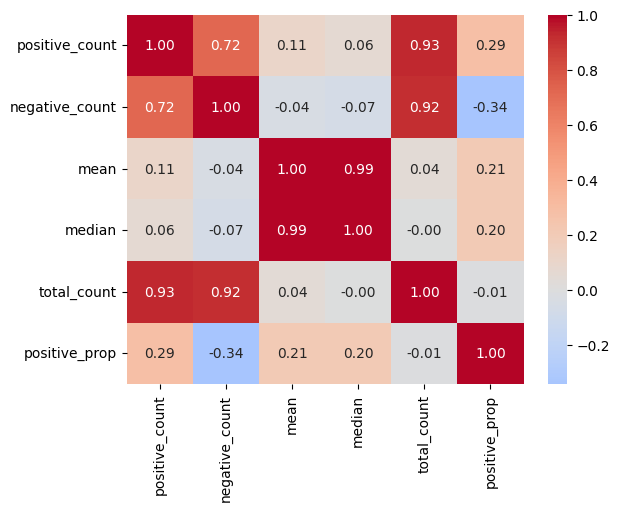

In [33]:
sns.heatmap(df_diff_type_grp.select_dtypes(include=NUMERICS).corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)

C:\Users\celva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\celva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

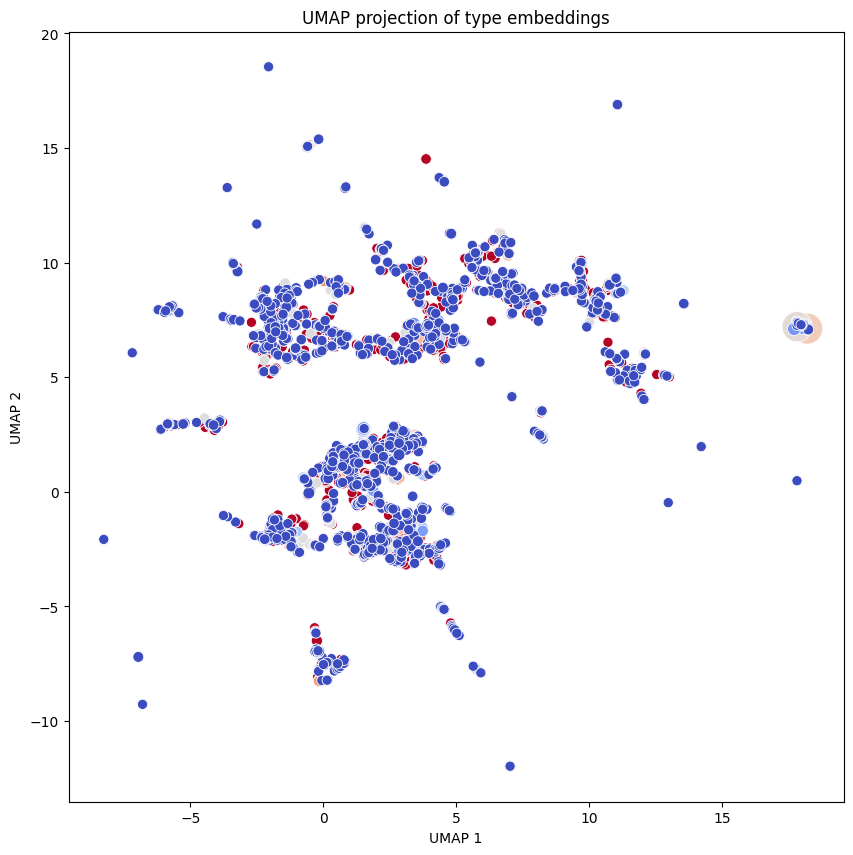

In [ ]:
from sentence_transformers import SentenceTransformer, util
from umap import UMAP

model = SentenceTransformer('all-MiniLM-L6-v2')
df_diff_type_grp['embedding'] = df_diff_type_grp['type'].apply(lambda x: model.encode(x, convert_to_tensor=True))
df_diff_type_grp['embedding'] = df_diff_type_grp['embedding'].apply(lambda x: x.cpu().numpy())

ump = UMAP(n_neighbors=5, n_components=2, metric='cosine', random_state=42)
embeddings = np.array(df_diff_type_grp['embedding'].tolist())

embeddings_2d = ump.fit_transform(embeddings)
df_diff_type_grp['x'] = embeddings_2d[:, 0]
df_diff_type_grp['y'] = embeddings_2d[:, 1]
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_diff_type_grp, x='x', y='y', hue='positive_prop', palette='coolwarm', size='total_count', sizes=(50, 500), legend=None)
plt.title('UMAP projection of type embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()



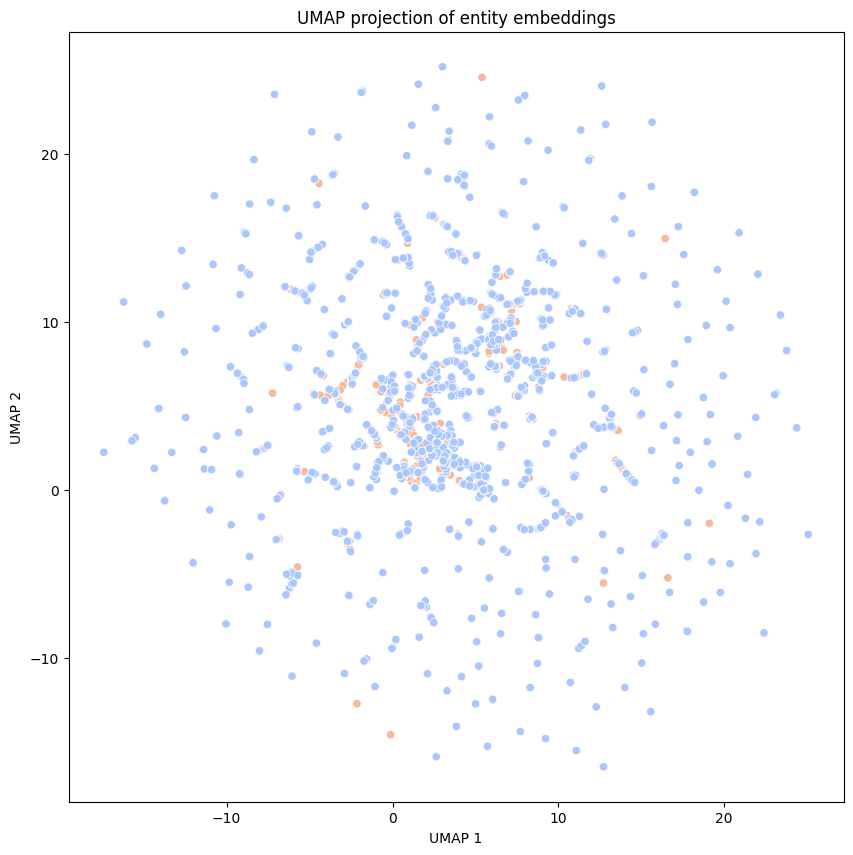

In [42]:
# df_rank_diff['embedding'] = df_rank_diff['entity'].apply(lambda x: model.encode(x, convert_to_tensor=True))
# df_rank_diff['embedding'] = df_rank_diff['embedding'].apply(lambda x: x.cpu().numpy())

# ump = UMAP(n_neighbors=5, n_components=2, metric='cosine', random_state=42)
# embeddings = np.array(df_rank_diff['embedding'].tolist())

# embeddings_2d = ump.fit_transform(embeddings)
# df_rank_diff['x'] = embeddings_2d[:, 0]
# df_rank_diff['y'] = embeddings_2d[:, 1]

df_rank_diff['is_positive'] = df_rank_diff['upgrade_score'] >= 0

plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_rank_diff, x='x', y='y', hue='is_positive', palette='coolwarm', sizes=(50, 500), legend=None)
plt.title('UMAP projection of entity embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()